# GNNs for Slow Slip Events

### Setup

In [1]:
# packages
import torch
import pandas as pd
from pygsig.datasets.subduction import SubductionZone
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Download data

dataset = SubductionZone(poly_path='datasets/subduction/polygon.geojson',
                         rast_path='datasets/subduction/interface.grd',
                         label_path='datasets/subduction/nonlinear.json',
                         data_path='datasets/subduction/data.geojson',
                         site_path='datasets/subduction/location.geojson',
                         start_date=pd.Timestamp('2008-01-01 11:59:00+0000', tz='UTC'),
                         end_date=pd.Timestamp('2023-12-31 11:59:00+0000', tz='UTC'),
                         download=False)

### Visualize the stations

In [56]:
import matplotlib.pyplot as plt

# get graph
dataset.task = 'classification'
seq = dataset.get_graph(k=5,normalize=True)

blue = '#3b4cc0'
red = '#b70d28'

G = nx.Graph()
G.add_nodes_from(range(seq.num_nodes))
G.add_edges_from(seq[0].edge_index.T.tolist())

pos = {node: position.numpy() for node, position in enumerate(seq[0].pos)}
depth = {node: measurement.item() for node, measurement in enumerate(seq[0].y)}
vector_depth = np.array([depth[i] for i in range(len(depth))])

# Define color map based on labels
color_map = {0: blue, -1: 'black', 1: red}
node_colors = [color_map[depth[node]] for node in G.nodes]

plt.figure(figsize=(8, 10))
nx.draw_networkx_nodes(G, pos=pos, node_size=25, node_color=node_colors)
nx.draw_networkx_edges(G, pos=pos)
nx.draw_networkx_labels(G, pos={k: (v[0], v[1] + 10000) for k, v in pos.items()}, labels={i: test_dataset.siteIDs[i] for i in range(len(test_dataset.siteIDs))}, font_size=6)
plt.title('GNSS Network')
plt.axis('off')

# Create legend
import matplotlib.patches as mpatches
linear_patch = mpatches.Patch(color=blue, label='Linear')
nonlinear_patch = mpatches.Patch(color=red, label='Nonlinear')
unlabeled_patch = mpatches.Patch(color='black', label='Unlabeled')
plt.legend(handles=[linear_patch, nonlinear_patch, unlabeled_patch])
plt.show()


AttributeError: 'TensorDataset' object has no attribute 'get_graph'

## Classification

### Encoder: TS2Vec

GNN with TS2Vec features trained on training data in each split seperately

Model: GCNClassification
Number of parameters: 41217
Split 1/3


100%|██████████| 10/10 [00:03<00:00,  2.60it/s]


Split 2/3


100%|██████████| 10/10 [00:03<00:00,  2.75it/s]


Split 3/3


100%|██████████| 10/10 [00:03<00:00,  2.78it/s]

Accuracy: 0.8601 ± 0.0725, F1: 0.5714 ± 0.1952, Precision: 0.6333 ± 0.2900, Recall: 0.6200 ± 0.2833


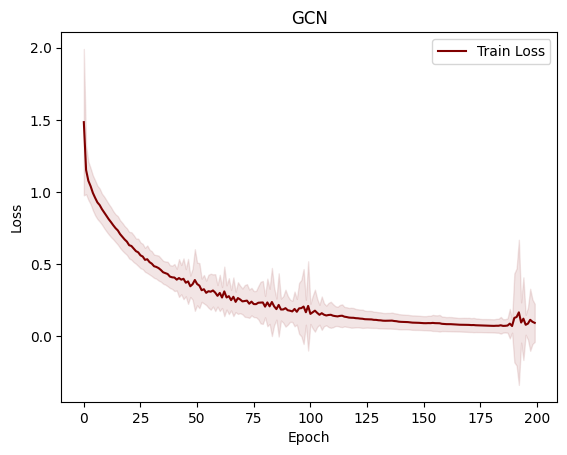

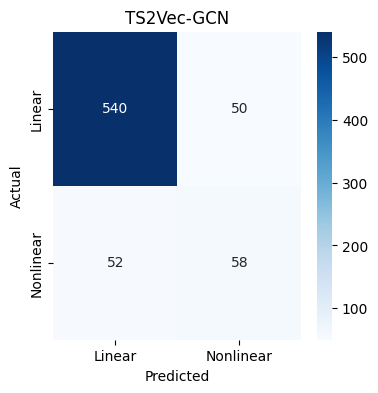

In [48]:
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
from sklearn.preprocessing import StandardScaler
import pygsig.graph 
import pygsig.models
import pygsig.signature
from pygsig.models import GCNClassification,MLPClassification
from pygsig.graph import split_nodes
from pygsig.transforms import SignatureFeatures,TS2VecFeatures,RandomFeatures
from ts2vec.ts2vec import TS2Vec
import signatory

# graph & task
dataset.task = 'classification'
seq = dataset.get_graph(k=5)


# Set up parameters
num_nodes = seq.num_nodes
num_splits = 3
num_trials = 10
num_epochs = 200
learning_rate = 1e-3
weight_decay = 1e-4
in_channels = 512
num_hidden = 64

print_during_training = False
retrain_encoder = False

# Create class weights for handling imbalance
positive_class_count = (seq.y == 1).sum().item()
negative_class_count = (seq.y == 0).sum().item()
class_weights = torch.tensor([negative_class_count / positive_class_count], dtype=torch.float)

# Initialize models
models = []
models.append(GCNClassification(num_channels=[in_channels, num_hidden, num_hidden, num_hidden, 1]))

model_names = ['GCN']

# Create a mask for valid labels (ignoring -1)
label_mask = seq.y != -1

# Criterion for binary classification with BCEWithLogitsLoss
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)

for model_number, model in enumerate(models):
    print(f'Model: {model._get_name()}')
    print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weight_decay)
    
    # Initialize arrays to store losses
    train_losses = np.zeros([num_splits, num_trials, num_epochs])
    eval_losses = np.zeros([num_splits, num_trials, num_epochs])
    
    accuracy = np.zeros([num_splits, num_trials])
    f1 = np.zeros([num_splits, num_trials])
    precision = np.zeros([num_splits, num_trials])
    recall = np.zeros([num_splits, num_trials])
    confusion_matrices = np.zeros([num_splits, num_trials, 2, 2])
    predictions = np.zeros([num_splits,num_trials,num_nodes])
    
    splits = split_nodes(num_nodes, num_splits, seed=31) # no validation
    
    for split in range(num_splits):
        print(f'Split {split+1}/{num_splits}')
        train_indices, test_indices = splits[split]
        
        # Create masks for training, evaluation, and testing
        train_mask = torch.zeros(num_nodes, dtype=torch.bool)
        test_mask = torch.zeros(num_nodes, dtype=torch.bool)
        
        train_mask[train_indices] = True
        test_mask[test_indices] = True
        
        # Apply label mask to exclude -1 values
        valid_train_mask = train_mask & label_mask
        valid_test_mask = test_mask & label_mask

        if retrain_encoder:
            # train encoder on the training data
            X_train = dataset.X[train_mask]
            encoder = TS2Vec(input_dims=3,device='cpu', hidden_dims=64, output_dims=in_channels,batch_size=1)
            loss_log = encoder.fit(X_train,verbose=True)
            torch.save(encoder,f'encoders/geonet/splits/TS2Vec_{split}.pt')
        else:
            # load encoder if already trained
            encoder = torch.load(f'encoders/geonet/splits/TS2Vec_{split}.pt')
        
        # Apply signature transformation to the sequential data to obtain static graph
        ts2vec = TS2VecFeatures(encoder,normalize=False)
        data = ts2vec(seq)

        with tqdm(total=num_trials, disable=print_during_training) as pbar:
            for trial in range(num_trials):
                model.reset_parameters()
                for epoch in range(num_epochs):
                    # Training phase
                    model.train()
                    optimizer.zero_grad()
                    out = model(data.x, data.edge_index)
                    
                    # Apply valid train mask to loss computation
                    train_loss = criterion(out[valid_train_mask], seq.y[valid_train_mask].unsqueeze(1))
                    train_loss.backward()
                    optimizer.step()

                    # Evaluation phase
                    model.eval()
                    with torch.no_grad():
                        test_loss = criterion(out[valid_test_mask], seq.y[valid_test_mask].unsqueeze(1))
                        train_losses[split, trial, epoch] = train_loss.item()
                    
                    if epoch % 10 == 0 and print_during_training:
                        print(f'Split {split}, Trial {trial}, Epoch {epoch}, Train Loss: {train_loss.item():.4f}')

                # Evaluation on test set with valid labels
                with torch.no_grad():
                    out = model(data.x, data.edge_index, data.edge_attr)
                    y_true = seq.y.unsqueeze(1)
                    y_pred = (out > 0.5).float()  # Binary predictions
                    
                    # Compute performance metrics
                    confusion_matrices[split, trial] = confusion_matrix(y_true[valid_test_mask].numpy(), y_pred[valid_test_mask].numpy())
                    accuracy[split, trial] = accuracy_score(y_true[valid_test_mask].numpy(), y_pred[valid_test_mask].numpy())
                    f1[split, trial] = f1_score(y_true[valid_test_mask].numpy(), y_pred[valid_test_mask].numpy(), zero_division=0)
                    precision[split, trial] = precision_score(y_true[valid_test_mask].numpy(), y_pred[valid_test_mask].numpy(),zero_division=0)
                    recall[split, trial] = recall_score(y_true[valid_test_mask].numpy(), y_pred[valid_test_mask].numpy(), zero_division=0)
                    predictions[split,trial] = y_pred.squeeze().numpy()

                    # Update the progress bar
                    pbar.update(1)


    # Print results for the model
    print(f'Accuracy: {np.mean(accuracy):.4f} ± {np.std(accuracy):.4f}, F1: {np.mean(f1):.4f} ± {np.std(f1):.4f}, Precision: {np.mean(precision):.4f} ± {np.std(precision):.4f}, Recall: {np.mean(recall):.4f} ± {np.std(recall):.4f}')

    # Plotting the training and evaluation loss
    avg_train_losses = np.mean(train_losses, axis=(0, 1))
    std_train_losses = np.std(train_losses, axis=(0, 1))
 

    plt.figure()
    plt.plot(avg_train_losses, label='Train Loss', color='maroon')
    plt.fill_between(range(num_epochs), avg_train_losses - std_train_losses, avg_train_losses + std_train_losses, alpha=0.1, color='maroon')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_names[model_number]}')
    plt.legend()
    plt.show()


    # Plot confusion matrices
    cm = confusion_matrices.sum(axis=(0,1))
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt=".0f", cmap="Blues", xticklabels=['Linear', 'Nonlinear'], yticklabels=['Linear', 'Nonlinear'])
    plt.title(f'TS2Vec-GCN')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    plt.show()

In [ ]:
print(f'positive proportion: {positive_class_count/(positive_class_count+negative_class_count):.4f}')

positive proportion: 0.1571


In [46]:
agg_predictions = predictions[:,:,label_mask].mean(axis=(0,1)) > 0.5
ground_truth = (data.y[label_mask] == 1).numpy()

disagreement_indices = np.where(agg_predictions != ground_truth)[0]
print("Disagreement stations:", dataset.gdf_location.iloc[disagreement_indices].siteID.values)


Disagreement stations: ['ANAU' 'CKID' 'CNST' 'FRTN' 'HAST' 'KAPT' 'KORO' 'KUTA' 'NMAI' 'NRSW'
 'OHIN']


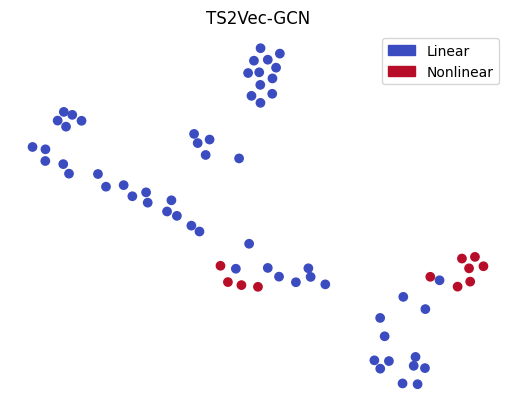

In [25]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

sig_latent_variables = model.conv[1](model.conv[0](data.x, data.edge_index),data.edge_index)

tsne = TSNE(n_components=2, perplexity=10, random_state=31)
X_embedded = tsne.fit_transform(sig_latent_variables.detach().numpy())

label_mask = data.y != -1

# Define color map based on labels
color_map = {0: blue, 1: red}
node_colors = [color_map[label.item()] for label in data.y[label_mask]]

plt.figure()
scatter = plt.scatter(X_embedded[label_mask, 0], X_embedded[label_mask, 1], c=node_colors)

# Add labels to the scatter plot
# for i, txt in enumerate(np.array(train_dataset.stations)[label_mask]):
#     plt.annotate(txt, (X_embedded[label_mask, 0][i], X_embedded[label_mask, 1][i]), fontsize=6)

plt.legend(handles=[mpatches.Patch(color=blue, label='Linear'), mpatches.Patch(color=red, label='Nonlinear')])
plt.title('TS2Vec-GCN')
plt.axis('off')
plt.show()

Save results

In [123]:
import pickle

with open('results/subduction/predictions/ts2vec.pkl','wb') as f:
    pickle.dump(predictions,f)

with open('results/subduction/accuracy/ts2vec.pkl','wb') as f:
    pickle.dump(accuracy,f)

with open('results/subduction/recall/ts2vec.pkl','wb') as f:
    pickle.dump(recall,f)

#### TS2Vec encoder (alternative training)

GNN with TS2Vec features trained on training data temporally nonoverlapping (works slightly better...maybe)

In [ ]:
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
from sklearn.preprocessing import StandardScaler
import pygsig.graph 
import pygsig.models
import pygsig.signature
from pygsig.models import GCNClassification,MLPClassification
from pygsig.graph import split_nodes
from pygsig.transforms import SignatureFeatures,TS2VecFeatures,RandomFeatures
from ts2vec.ts2vec import TS2Vec
import signatory

# graph & task
test_dataset.task = 'classification'
seq = test_dataset.get_graph(k=5)

# Set up parameters
num_nodes = seq.num_nodes
num_splits = 4
num_trials = 10
num_epochs = 200
learning_rate = 1e-3
in_channels = signatory.signature_channels(2*seq.num_node_features,3)
num_hidden = 64

print_during_training = False
retrain_encoder = False

# Create class weights for handling imbalance
positive_class_count = (seq.y == 1).sum().item()
negative_class_count = (seq.y == 0).sum().item()
class_weights = torch.tensor([negative_class_count / positive_class_count], dtype=torch.float)

# Initialize models
models = []
models.append(GCNClassification(num_channels=[in_channels, num_hidden, num_hidden, 1]))

model_names = ['GCN']

# Create a mask for valid labels (ignoring -1)
label_mask = seq.y != -1

# Criterion for binary classification with BCEWithLogitsLoss
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)

if retrain_encoder:
    X_train = train_dataset.X
    encoder = TS2Vec(input_dims=3,device='cpu', hidden_dims=64, output_dims=in_channels,batch_size=1)
    loss_log = encoder.fit(X_train,verbose=True)
    torch.save(encoder,f'encoders/geonet/train/TS2Vec.pt')
else:
    encoder = torch.load(f'encoders/geonet/train/TS2Vec.pt')

# Apply signature transformation to the sequential data to obtain static graph
ts2vec = TS2VecFeatures(encoder,normalize=False)
data = ts2vec(seq)

for model_number, model in enumerate(models):
    print(f'Model: {model._get_name()}')
    print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Initialize arrays to store losses
    train_losses = np.zeros([num_splits, num_trials, num_epochs])
    eval_losses = np.zeros([num_splits, num_trials, num_epochs])
    
    accuracy = np.zeros([num_splits, num_trials])
    f1 = np.zeros([num_splits, num_trials])
    precision = np.zeros([num_splits, num_trials])
    recall = np.zeros([num_splits, num_trials])
    confusion_matrices = np.zeros([num_splits, num_trials, 2, 2])
    predictions = np.zeros([num_splits,num_trials,num_nodes])
    
    splits = split_nodes(num_nodes, num_splits, seed=31) # no validation
    
    for split in range(num_splits):
        print(f'Split {split+1}/{num_splits}')
        train_indices, test_indices = splits[split]
        
        # Create masks for training, evaluation, and testing
        train_mask = torch.zeros(num_nodes, dtype=torch.bool)
        test_mask = torch.zeros(num_nodes, dtype=torch.bool)
        
        train_mask[train_indices] = True
        test_mask[test_indices] = True
        
        # Apply label mask to exclude -1 values
        valid_train_mask = train_mask & label_mask
        valid_test_mask = test_mask & label_mask

        with tqdm(total=num_trials, disable=print_during_training) as pbar:
            for trial in range(num_trials):
                model.reset_parameters()
                for epoch in range(num_epochs):
                    # Training phase
                    model.train()
                    optimizer.zero_grad()
                    out = model(data.x, data.edge_index)
                    
                    # Apply valid train mask to loss computation
                    train_loss = criterion(out[valid_train_mask], data.y[valid_train_mask].unsqueeze(1))
                    train_loss.backward()
                    optimizer.step()

                    # Evaluation phase
                    model.eval()
                    with torch.no_grad():
                        test_loss = criterion(out[valid_test_mask], data.y[valid_test_mask].unsqueeze(1))
                        train_losses[split, trial, epoch] = train_loss.item()
                    
                    if epoch % 10 == 0 and print_during_training:
                        print(f'Split {split}, Trial {trial}, Epoch {epoch}, Train Loss: {train_loss.item():.4f}')

                # Evaluation on test set with valid labels
                with torch.no_grad():
                    out = model(data.x, data.edge_index, data.edge_attr)
                    y_true = data.y.unsqueeze(1)
                    y_pred = (out > 0.5).float()  # Binary predictions
                    
                    # Compute performance metrics
                    confusion_matrices[split, trial] = confusion_matrix(y_true[valid_test_mask].numpy(), y_pred[valid_test_mask].numpy())
                    accuracy[split, trial] = accuracy_score(y_true[valid_test_mask].numpy(), y_pred[valid_test_mask].numpy())
                    f1[split, trial] = f1_score(y_true[valid_test_mask].numpy(), y_pred[valid_test_mask].numpy(), zero_division=0)
                    precision[split, trial] = precision_score(y_true[valid_test_mask].numpy(), y_pred[valid_test_mask].numpy(),zero_division=0)
                    recall[split, trial] = recall_score(y_true[valid_test_mask].numpy(), y_pred[valid_test_mask].numpy(), zero_division=0)
                    predictions[split,trial] = y_pred.squeeze().numpy()

                    # Update the progress bar
                    pbar.update(1)


    # Print results for the model
    print(f'Accuracy: {np.mean(accuracy):.4f} ± {np.std(accuracy):.4f}, F1: {np.mean(f1):.4f} ± {np.std(f1):.4f}, Precision: {np.mean(precision):.4f} ± {np.std(precision):.4f}, Recall: {np.mean(recall):.4f} ± {np.std(recall):.4f}')

    # Plotting the training and evaluation loss
    avg_train_losses = np.mean(train_losses, axis=(0, 1))
    std_train_losses = np.std(train_losses, axis=(0, 1))
 

    plt.figure()
    plt.plot(avg_train_losses, label='Train Loss', color='maroon')
    plt.fill_between(range(num_epochs), avg_train_losses - std_train_losses, avg_train_losses + std_train_losses, alpha=0.1, color='maroon')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_names[model_number]}')
    plt.legend()
    plt.show()


    # Plot confusion matrices
    cm = confusion_matrices.sum(axis=(0,1))
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt=".0f", cmap="Blues", xticklabels=['Linear', 'Nonlinear'], yticklabels=['Linear', 'Nonlinear'])
    plt.title(f'TS2Vec-GCN')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [182]:
agg_predictions = predictions[:,:,label_mask].mean(axis=(0,1)) > 0.0
ground_truth = (data.y[label_mask] == 1).numpy()

disagreement_indices = np.where(agg_predictions != ground_truth)[0]
print("Disagreement stations:", train_dataset.gdf_location.iloc[disagreement_indices].siteID.values)


Disagreement stations: ['AHTI' 'TAUW']


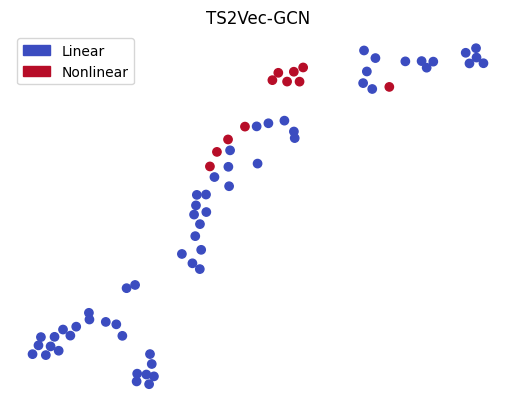

In [184]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

sig_latent_variables = model.conv[1](model.conv[0](data.x, data.edge_index),data.edge_index)

tsne = TSNE(n_components=2, perplexity=10, random_state=31)
X_embedded = tsne.fit_transform(sig_latent_variables.detach().numpy())

label_mask = data.y != -1

# Define color map based on labels
color_map = {0: blue, 1: red}
node_colors = [color_map[label.item()] for label in data.y[label_mask]]

plt.figure()
scatter = plt.scatter(X_embedded[label_mask, 0], X_embedded[label_mask, 1], c=node_colors)

plt.legend(handles=[mpatches.Patch(color=blue, label='Linear'), mpatches.Patch(color=red, label='Nonlinear')])
plt.title('TS2Vec-GCN')
plt.axis('off')
plt.show()

### Encoder: lead-lag path signature 

Model: GCNClassification
Number of parameters: 20801
Split 1/4


100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


Split 2/4


100%|██████████| 10/10 [00:03<00:00,  2.85it/s]


Split 3/4


100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


Split 4/4


100%|██████████| 10/10 [00:03<00:00,  3.02it/s]

Accuracy: 0.9254 ± 0.0538, F1: 0.5556 ± 0.3333, Precision: 0.6167 ± 0.3753, Recall: 0.5417 ± 0.3608


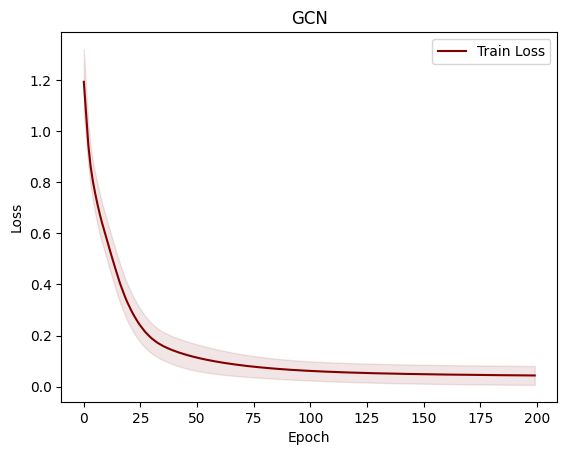

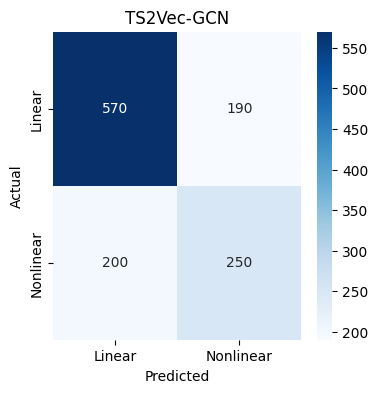

In [147]:
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
from sklearn.preprocessing import StandardScaler
import pygsig.graph 
import pygsig.models
import pygsig.signature
from pygsig.models import GCNClassification,MLPClassification
from pygsig.graph import split_nodes
from pygsig.transforms import SignatureFeatures,TS2VecFeatures,RandomFeatures
import signatory

# graph & task
test_dataset.task = 'classification'
seq = test_dataset.get_graph(k=5)

# Set up parameters
num_nodes = seq.num_nodes
num_splits = 4
num_trials = 10
num_epochs = 200
learning_rate = 1e-3
in_channels = signatory.signature_channels(2*seq.num_node_features,3)
num_hidden = 64

print_during_training = False
retrain_encoder = True

# Create class weights for handling imbalance
positive_class_count = (seq.y == 1).sum().item()
negative_class_count = (seq.y == 0).sum().item()
class_weights = torch.tensor([negative_class_count / positive_class_count], dtype=torch.float)

# Initialize models
models = []
models.append(GCNClassification(num_channels=[in_channels, num_hidden, num_hidden, 1]))

model_names = ['GCN']

# Create a mask for valid labels (ignoring -1)
label_mask = seq.y != -1

# Criterion for binary classification with BCEWithLogitsLoss
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)

# Apply signature transformation to the sequential data to obtain static graph
sig2vec = SignatureFeatures(sig_depth=3,lead_lag=True,normalize=True)
data = sig2vec(seq)

for model_number, model in enumerate(models):
    print(f'Model: {model._get_name()}')
    print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Initialize arrays to store losses
    train_losses = np.zeros([num_splits, num_trials, num_epochs])
    eval_losses = np.zeros([num_splits, num_trials, num_epochs])
    
    accuracy = np.zeros([num_splits, num_trials])
    f1 = np.zeros([num_splits, num_trials])
    precision = np.zeros([num_splits, num_trials])
    recall = np.zeros([num_splits, num_trials])
    confusion_matrices = np.zeros([num_splits, num_trials, 2, 2])
    predictions = np.zeros([num_splits,num_trials,num_nodes])
    
    splits = split_nodes(num_nodes, num_splits, seed=31) # no validation
    
    for split in range(num_splits):
        print(f'Split {split+1}/{num_splits}')
        train_indices, test_indices = splits[split]
        
        # Create masks for training, evaluation, and testing
        train_mask = torch.zeros(num_nodes, dtype=torch.bool)
        test_mask = torch.zeros(num_nodes, dtype=torch.bool)
        
        train_mask[train_indices] = True
        test_mask[test_indices] = True
        
        # Apply label mask to exclude -1 values
        valid_train_mask = train_mask & label_mask
        valid_test_mask = test_mask & label_mask

        with tqdm(total=num_trials, disable=print_during_training) as pbar:
            for trial in range(num_trials):
                model.reset_parameters()
                for epoch in range(num_epochs):
                    # Training phase
                    model.train()
                    optimizer.zero_grad()
                    out = model(data.x, data.edge_index)
                    
                    # Apply valid train mask to loss computation
                    train_loss = criterion(out[valid_train_mask], data.y[valid_train_mask].unsqueeze(1))
                    train_loss.backward()
                    optimizer.step()

                    # Evaluation phase
                    model.eval()
                    with torch.no_grad():
                        test_loss = criterion(out[valid_test_mask], data.y[valid_test_mask].unsqueeze(1))
                        train_losses[split, trial, epoch] = train_loss.item()
                    
                    if epoch % 10 == 0 and print_during_training:
                        print(f'Split {split}, Trial {trial}, Epoch {epoch}, Train Loss: {train_loss.item():.4f}')

                # Evaluation on test set with valid labels
                with torch.no_grad():
                    out = model(data.x, data.edge_index, data.edge_attr)
                    y_true = data.y.unsqueeze(1)
                    y_pred = (out > 0.5).float()  # Binary predictions
                    
                    # Compute performance metrics
                    confusion_matrices[split, trial] = confusion_matrix(y_true[valid_test_mask].numpy(), y_pred[valid_test_mask].numpy())
                    accuracy[split, trial] = accuracy_score(y_true[valid_test_mask].numpy(), y_pred[valid_test_mask].numpy())
                    f1[split, trial] = f1_score(y_true[valid_test_mask].numpy(), y_pred[valid_test_mask].numpy(), zero_division=0)
                    precision[split, trial] = precision_score(y_true[valid_test_mask].numpy(), y_pred[valid_test_mask].numpy(),zero_division=0)
                    recall[split, trial] = recall_score(y_true[valid_test_mask].numpy(), y_pred[valid_test_mask].numpy(), zero_division=0)
                    predictions[split,trial] = y_pred.squeeze().numpy()

                    # Update the progress bar
                    pbar.update(1)


    # Print results for the model
    print(f'Accuracy: {np.mean(accuracy):.4f} ± {np.std(accuracy):.4f}, F1: {np.mean(f1):.4f} ± {np.std(f1):.4f}, Precision: {np.mean(precision):.4f} ± {np.std(precision):.4f}, Recall: {np.mean(recall):.4f} ± {np.std(recall):.4f}')

    # Plotting the training and evaluation loss
    avg_train_losses = np.mean(train_losses, axis=(0, 1))
    std_train_losses = np.std(train_losses, axis=(0, 1))
 

    plt.figure()
    plt.plot(avg_train_losses, label='Train Loss', color='maroon')
    plt.fill_between(range(num_epochs), avg_train_losses - std_train_losses, avg_train_losses + std_train_losses, alpha=0.1, color='maroon')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_names[model_number]}')
    plt.legend()
    plt.show()


    # Plot confusion matrices
    cm = confusion_matrices.sum(axis=(0,1))
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt=".0f", cmap="Blues", xticklabels=['Linear', 'Nonlinear'], yticklabels=['Linear', 'Nonlinear'])
    plt.title(f'TS2Vec-GCN')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [148]:
agg_predictions = predictions[:,:,label_mask].mean(axis=(0,1)) > 0
ground_truth = (data.y[label_mask] == 1).numpy()

disagreement_indices = np.where(agg_predictions != ground_truth)[0]
print("Disagreement stations:", train_dataset.gdf_location.iloc[disagreement_indices].siteID.values)


Disagreement stations: ['AHTI' 'TAUW']


Save results

In [149]:
import pickle

with open('results/subduction/predictions/sig_leadlag.pkl','wb') as f:
    pickle.dump(predictions,f)

with open('results/subduction/accuracy/sig_leadlag.pkl','wb') as f:
    pickle.dump(accuracy,f)

with open('results/subduction/recall/sig_leadlag.pkl','wb') as f:
    pickle.dump(recall,f)

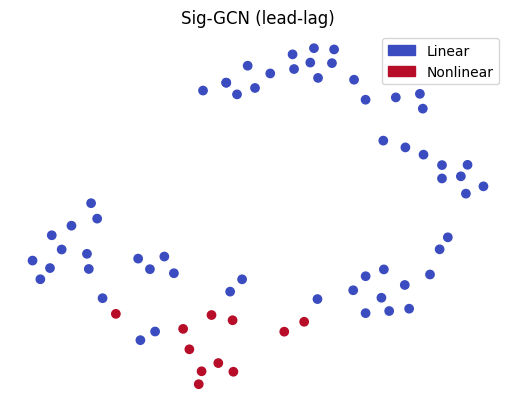

In [150]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

sig_latent_variables = model.conv[1](model.conv[0](data.x, data.edge_index),data.edge_index)

tsne = TSNE(n_components=2, perplexity=10, random_state=31)
X_embedded = tsne.fit_transform(sig_latent_variables.detach().numpy())

label_mask = data.y != -1

# Define color map based on labels
color_map = {0: blue, 1: red}
node_colors = [color_map[label.item()] for label in data.y[label_mask]]

plt.figure()
scatter = plt.scatter(X_embedded[label_mask, 0], X_embedded[label_mask, 1], c=node_colors)

plt.legend(handles=[mpatches.Patch(color=blue, label='Linear'), mpatches.Patch(color=red, label='Nonlinear')])
plt.title('Sig-GCN (lead-lag)')
plt.axis('off')
plt.show()

### Encoder: raw path signature

Model: GCNClassification
Number of parameters: 6785
Split 1/4


100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


Split 2/4


100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


Split 3/4


100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


Split 4/4


100%|██████████| 10/10 [00:03<00:00,  3.25it/s]

Accuracy: 0.9254 ± 0.0538, F1: 0.5556 ± 0.3333, Precision: 0.6167 ± 0.3753, Recall: 0.5417 ± 0.3608


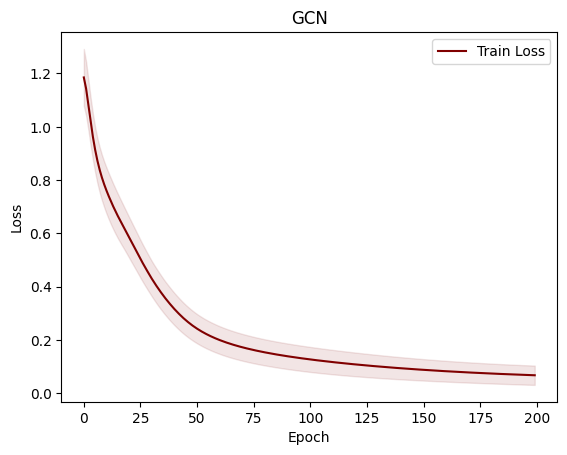

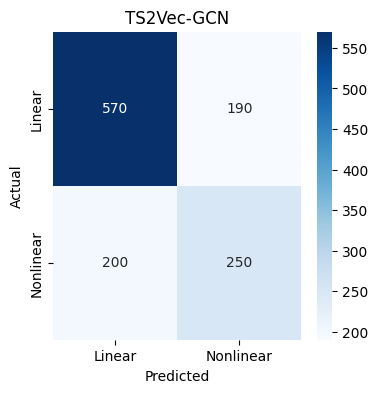

In [141]:
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
from sklearn.preprocessing import StandardScaler
import pygsig.graph 
import pygsig.models
import pygsig.signature
from pygsig.models import GCNClassification,MLPClassification
from pygsig.graph import split_nodes
from pygsig.transforms import SignatureFeatures,TS2VecFeatures,RandomFeatures
import signatory

# graph & task
test_dataset.task = 'classification'
seq = test_dataset.get_graph(k=5)

# Set up parameters
num_nodes = seq.num_nodes
num_splits = 4
num_trials = 10
num_epochs = 200
learning_rate = 1e-3
in_channels = signatory.signature_channels(seq.num_node_features,3)
num_hidden = 64

print_during_training = False
retrain_encoder = True

# Create class weights for handling imbalance
positive_class_count = (seq.y == 1).sum().item()
negative_class_count = (seq.y == 0).sum().item()
class_weights = torch.tensor([negative_class_count / positive_class_count], dtype=torch.float)

# Initialize models
models = []
models.append(GCNClassification(num_channels=[in_channels, num_hidden, num_hidden, 1]))

model_names = ['GCN']

# Create a mask for valid labels (ignoring -1)
label_mask = seq.y != -1

# Criterion for binary classification with BCEWithLogitsLoss
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)

# Apply signature transformation to the sequential data to obtain static graph
sig2vec = SignatureFeatures(sig_depth=3,lead_lag=False,normalize=True)
data = sig2vec(seq)

for model_number, model in enumerate(models):
    print(f'Model: {model._get_name()}')
    print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Initialize arrays to store losses
    train_losses = np.zeros([num_splits, num_trials, num_epochs])
    eval_losses = np.zeros([num_splits, num_trials, num_epochs])
    
    accuracy = np.zeros([num_splits, num_trials])
    f1 = np.zeros([num_splits, num_trials])
    precision = np.zeros([num_splits, num_trials])
    recall = np.zeros([num_splits, num_trials])
    confusion_matrices = np.zeros([num_splits, num_trials, 2, 2])
    predictions = np.zeros([num_splits,num_trials,num_nodes])
    
    splits = split_nodes(num_nodes, num_splits, seed=31) # no validation
    
    for split in range(num_splits):
        print(f'Split {split+1}/{num_splits}')
        train_indices, test_indices = splits[split]
        
        # Create masks for training, evaluation, and testing
        train_mask = torch.zeros(num_nodes, dtype=torch.bool)
        test_mask = torch.zeros(num_nodes, dtype=torch.bool)
        
        train_mask[train_indices] = True
        test_mask[test_indices] = True
        
        # Apply label mask to exclude -1 values
        valid_train_mask = train_mask & label_mask
        valid_test_mask = test_mask & label_mask

        with tqdm(total=num_trials, disable=print_during_training) as pbar:
            for trial in range(num_trials):
                model.reset_parameters()
                for epoch in range(num_epochs):
                    # Training phase
                    model.train()
                    optimizer.zero_grad()
                    out = model(data.x, data.edge_index)
                    
                    # Apply valid train mask to loss computation
                    train_loss = criterion(out[valid_train_mask], data.y[valid_train_mask].unsqueeze(1))
                    train_loss.backward()
                    optimizer.step()

                    # Evaluation phase
                    model.eval()
                    with torch.no_grad():
                        test_loss = criterion(out[valid_test_mask], data.y[valid_test_mask].unsqueeze(1))
                        train_losses[split, trial, epoch] = train_loss.item()
                    
                    if epoch % 10 == 0 and print_during_training:
                        print(f'Split {split}, Trial {trial}, Epoch {epoch}, Train Loss: {train_loss.item():.4f}')

                # Evaluation on test set with valid labels
                with torch.no_grad():
                    out = model(data.x, data.edge_index, data.edge_attr)
                    y_true = data.y.unsqueeze(1)
                    y_pred = (out > 0.5).float()  # Binary predictions
                    
                    # Compute performance metrics
                    confusion_matrices[split, trial] = confusion_matrix(y_true[valid_test_mask].numpy(), y_pred[valid_test_mask].numpy())
                    accuracy[split, trial] = accuracy_score(y_true[valid_test_mask].numpy(), y_pred[valid_test_mask].numpy())
                    f1[split, trial] = f1_score(y_true[valid_test_mask].numpy(), y_pred[valid_test_mask].numpy(), zero_division=0)
                    precision[split, trial] = precision_score(y_true[valid_test_mask].numpy(), y_pred[valid_test_mask].numpy(),zero_division=0)
                    recall[split, trial] = recall_score(y_true[valid_test_mask].numpy(), y_pred[valid_test_mask].numpy(), zero_division=0)
                    predictions[split,trial] = y_pred.squeeze().numpy()

                    # Update the progress bar
                    pbar.update(1)


    # Print results for the model
    print(f'Accuracy: {np.mean(accuracy):.4f} ± {np.std(accuracy):.4f}, F1: {np.mean(f1):.4f} ± {np.std(f1):.4f}, Precision: {np.mean(precision):.4f} ± {np.std(precision):.4f}, Recall: {np.mean(recall):.4f} ± {np.std(recall):.4f}')

    # Plotting the training and evaluation loss
    avg_train_losses = np.mean(train_losses, axis=(0, 1))
    std_train_losses = np.std(train_losses, axis=(0, 1))
 

    plt.figure()
    plt.plot(avg_train_losses, label='Train Loss', color='maroon')
    plt.fill_between(range(num_epochs), avg_train_losses - std_train_losses, avg_train_losses + std_train_losses, alpha=0.1, color='maroon')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_names[model_number]}')
    plt.legend()
    plt.show()


    # Plot confusion matrices
    cm = confusion_matrices.sum(axis=(0,1))
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt=".0f", cmap="Blues", xticklabels=['Linear', 'Nonlinear'], yticklabels=['Linear', 'Nonlinear'])
    plt.title(f'TS2Vec-GCN')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [144]:
agg_predictions = predictions[:,:,label_mask].mean(axis=(0,1)) > 0
ground_truth = (data.y[label_mask] == 1).numpy()

disagreement_indices = np.where(agg_predictions != ground_truth)[0]
print("Disagreement stations:", train_dataset.gdf_location.iloc[disagreement_indices].siteID.values)


Disagreement stations: ['AHTI' 'TAUW']


Save results

In [145]:
import pickle

with open('results/subduction/predictions/sig_raw.pkl','wb') as f:
    pickle.dump(predictions,f)

with open('results/subduction/accuracy/sig_raw.pkl','wb') as f:
    pickle.dump(accuracy,f)

with open('results/subduction/recall/sig_raw.pkl','wb') as f:
    pickle.dump(recall,f)

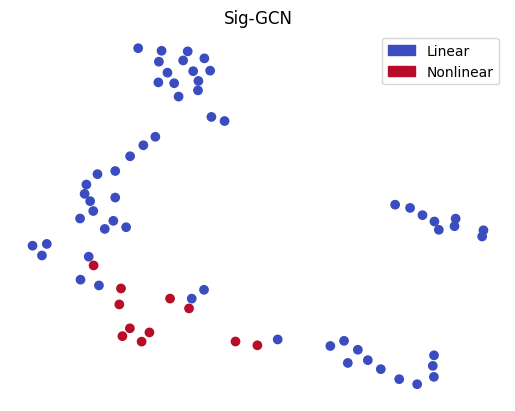

In [146]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

sig_latent_variables = model.conv[1](model.conv[0](data.x, data.edge_index),data.edge_index)

tsne = TSNE(n_components=2, perplexity=10, random_state=31)
X_embedded = tsne.fit_transform(sig_latent_variables.detach().numpy())

label_mask = data.y != -1

# Define color map based on labels
color_map = {0: blue, 1: red}
node_colors = [color_map[label.item()] for label in data.y[label_mask]]

plt.figure()
scatter = plt.scatter(X_embedded[label_mask, 0], X_embedded[label_mask, 1], c=node_colors)

# Add labels to the scatter plot
# for i, txt in enumerate(np.array(train_dataset.stations)[label_mask]):
#     plt.annotate(txt, (X_embedded[label_mask, 0][i], X_embedded[label_mask, 1][i]), fontsize=6)

plt.legend(handles=[mpatches.Patch(color=blue, label='Linear'), mpatches.Patch(color=red, label='Nonlinear')])
plt.title('Sig-GCN')
plt.axis('off')
plt.show()

### Encoder: random

Model: GCNClassification
Number of parameters: 20801
Split 1/4


100%|██████████| 10/10 [00:03<00:00,  2.89it/s]


Split 2/4


100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


Split 3/4


100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


Split 4/4


100%|██████████| 10/10 [00:03<00:00,  3.08it/s]

Accuracy: 0.9254 ± 0.0538, F1: 0.5556 ± 0.3333, Precision: 0.6167 ± 0.3753, Recall: 0.5417 ± 0.3608


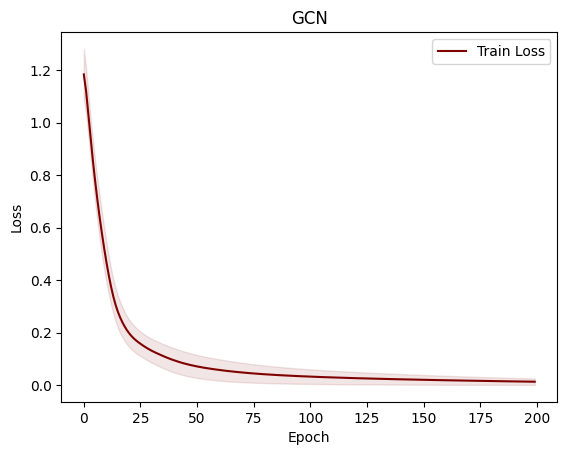

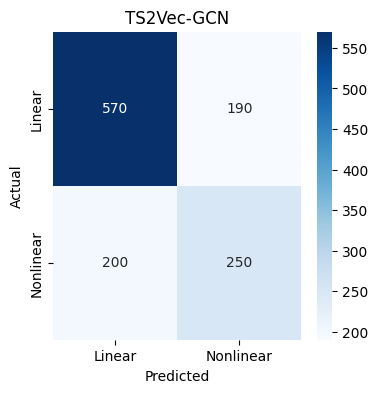

In [126]:
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
from sklearn.preprocessing import StandardScaler
import pygsig.graph 
import pygsig.models
import pygsig.signature
from pygsig.models import GCNClassification,MLPClassification
from pygsig.graph import split_nodes
from pygsig.transforms import SignatureFeatures,TS2VecFeatures,RandomFeatures
import signatory

# graph & task
test_dataset.task = 'classification'
seq = test_dataset.get_graph(k=5)

# Set up parameters
num_nodes = seq.num_nodes
num_splits = 4
num_trials = 10
num_epochs = 200
learning_rate = 1e-3
in_channels = signatory.signature_channels(2*seq.num_node_features,3)
num_hidden = 64

print_during_training = False
retrain_encoder = True

# Create class weights for handling imbalance
positive_class_count = (seq.y == 1).sum().item()
negative_class_count = (seq.y == 0).sum().item()
class_weights = torch.tensor([negative_class_count / positive_class_count], dtype=torch.float)

# Initialize models
models = []
models.append(GCNClassification(num_channels=[in_channels, num_hidden, num_hidden, 1]))

model_names = ['GCN']

# Create a mask for valid labels (ignoring -1)
label_mask = seq.y != -1

# Criterion for binary classification with BCEWithLogitsLoss
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)

# Apply signature transformation to the sequential data to obtain static graph
rand_encoder = RandomFeatures(num_features=in_channels)
data = rand_encoder(seq)

for model_number, model in enumerate(models):
    print(f'Model: {model._get_name()}')
    print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Initialize arrays to store losses
    train_losses = np.zeros([num_splits, num_trials, num_epochs])
    eval_losses = np.zeros([num_splits, num_trials, num_epochs])
    
    accuracy = np.zeros([num_splits, num_trials])
    f1 = np.zeros([num_splits, num_trials])
    precision = np.zeros([num_splits, num_trials])
    recall = np.zeros([num_splits, num_trials])
    confusion_matrices = np.zeros([num_splits, num_trials, 2, 2])
    predictions = np.zeros([num_splits,num_trials,num_nodes])
    
    splits = split_nodes(num_nodes, num_splits, seed=31) # no validation
    
    for split in range(num_splits):
        print(f'Split {split+1}/{num_splits}')
        train_indices, test_indices = splits[split]
        
        # Create masks for training, evaluation, and testing
        train_mask = torch.zeros(num_nodes, dtype=torch.bool)
        test_mask = torch.zeros(num_nodes, dtype=torch.bool)
        
        train_mask[train_indices] = True
        test_mask[test_indices] = True
        
        # Apply label mask to exclude -1 values
        valid_train_mask = train_mask & label_mask
        valid_test_mask = test_mask & label_mask

        with tqdm(total=num_trials, disable=print_during_training) as pbar:
            for trial in range(num_trials):
                model.reset_parameters()
                for epoch in range(num_epochs):
                    # Training phase
                    model.train()
                    optimizer.zero_grad()
                    out = model(data.x, data.edge_index)
                    
                    # Apply valid train mask to loss computation
                    train_loss = criterion(out[valid_train_mask], data.y[valid_train_mask].unsqueeze(1))
                    train_loss.backward()
                    optimizer.step()

                    # Evaluation phase
                    model.eval()
                    with torch.no_grad():
                        test_loss = criterion(out[valid_test_mask], data.y[valid_test_mask].unsqueeze(1))
                        train_losses[split, trial, epoch] = train_loss.item()
                    
                    if epoch % 10 == 0 and print_during_training:
                        print(f'Split {split}, Trial {trial}, Epoch {epoch}, Train Loss: {train_loss.item():.4f}')

                # Evaluation on test set with valid labels
                with torch.no_grad():
                    out = model(data.x, data.edge_index, data.edge_attr)
                    y_true = data.y.unsqueeze(1)
                    y_pred = (out > 0.5).float()  # Binary predictions
                    
                    # Compute performance metrics
                    confusion_matrices[split, trial] = confusion_matrix(y_true[valid_test_mask].numpy(), y_pred[valid_test_mask].numpy())
                    accuracy[split, trial] = accuracy_score(y_true[valid_test_mask].numpy(), y_pred[valid_test_mask].numpy())
                    f1[split, trial] = f1_score(y_true[valid_test_mask].numpy(), y_pred[valid_test_mask].numpy(), zero_division=0)
                    precision[split, trial] = precision_score(y_true[valid_test_mask].numpy(), y_pred[valid_test_mask].numpy(),zero_division=0)
                    recall[split, trial] = recall_score(y_true[valid_test_mask].numpy(), y_pred[valid_test_mask].numpy(), zero_division=0)
                    predictions[split,trial] = y_pred.squeeze().numpy()

                    # Update the progress bar
                    pbar.update(1)


    # Print results for the model
    print(f'Accuracy: {np.mean(accuracy):.4f} ± {np.std(accuracy):.4f}, F1: {np.mean(f1):.4f} ± {np.std(f1):.4f}, Precision: {np.mean(precision):.4f} ± {np.std(precision):.4f}, Recall: {np.mean(recall):.4f} ± {np.std(recall):.4f}')

    # Plotting the training and evaluation loss
    avg_train_losses = np.mean(train_losses, axis=(0, 1))
    std_train_losses = np.std(train_losses, axis=(0, 1))
 

    plt.figure()
    plt.plot(avg_train_losses, label='Train Loss', color='maroon')
    plt.fill_between(range(num_epochs), avg_train_losses - std_train_losses, avg_train_losses + std_train_losses, alpha=0.1, color='maroon')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_names[model_number]}')
    plt.legend()
    plt.show()


    # Plot confusion matrices
    cm = confusion_matrices.sum(axis=(0,1))
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt=".0f", cmap="Blues", xticklabels=['Linear', 'Nonlinear'], yticklabels=['Linear', 'Nonlinear'])
    plt.title(f'TS2Vec-GCN')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [128]:
agg_predictions = predictions[:,:,label_mask].mean(axis=(0,1)) > 0
ground_truth = (data.y[label_mask] == 1).numpy()

disagreement_indices = np.where(agg_predictions != ground_truth)[0]
print("Disagreement stations:", train_dataset.gdf_location.iloc[disagreement_indices].siteID.values)


Disagreement stations: ['AHTI' 'TAUW']


Save results

In [130]:
import pickle

with open('results/subduction/predictions/random.pkl','wb') as f:
    pickle.dump(predictions,f)

with open('results/subduction/accuracy/random.pkl','wb') as f:
    pickle.dump(accuracy,f)

with open('results/subduction/recall/random.pkl','wb') as f:
    pickle.dump(recall,f)

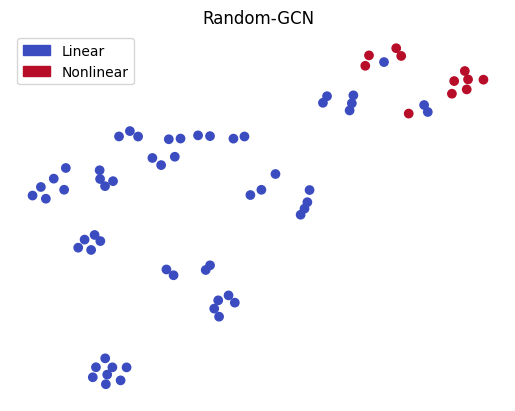

In [131]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

sig_latent_variables = model.conv[1](model.conv[0](data.x, data.edge_index),data.edge_index)

tsne = TSNE(n_components=2, perplexity=10, random_state=31)
X_embedded = tsne.fit_transform(sig_latent_variables.detach().numpy())

label_mask = data.y != -1

# Define color map based on labels
color_map = {0: blue, 1: red}
node_colors = [color_map[label.item()] for label in data.y[label_mask]]

plt.figure()
scatter = plt.scatter(X_embedded[label_mask, 0], X_embedded[label_mask, 1], c=node_colors)

# Add labels to the scatter plot
# for i, txt in enumerate(np.array(train_dataset.stations)[label_mask]):
#     plt.annotate(txt, (X_embedded[label_mask, 0][i], X_embedded[label_mask, 1][i]), fontsize=6)

plt.legend(handles=[mpatches.Patch(color=blue, label='Linear'), mpatches.Patch(color=red, label='Nonlinear')])
plt.title('Random-GCN')
plt.axis('off')
plt.show()

### Encoder: LSTM

In [51]:
import torch
import torch.nn as nn

class LSTMAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMAutoencoder, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Encoder
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Decoder
        self.decoder = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, input_size)
    
    def forward(self, x):
        # Encoder
        _, (hidden, cell) = self.encoder(x)
        
        # Use the last hidden state as the encoded representation
        encoded = hidden[-1]
        
        # Decoder
        decoded, _ = self.decoder(encoded.unsqueeze(1).repeat(1, x.size(1), 1))
        output = self.fc(decoded)
        
        return output, encoded

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


# Set random seed for reproducibility
torch.manual_seed(42)

# Parameters
input_size = 3  # Number of features in your 3D time series
hidden_size = 64
num_layers = 2
batch_size = 32
num_epochs = 100
learning_rate = 0.001

# Create DataLoader
X = torch.tensor(dataset.X).float()
dataset = TensorDataset(X)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model
model = LSTMAutoencoder(input_size, hidden_size, num_layers)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
losses = []
for epoch in range(num_epochs):
    epoch_loss = 0
    for batch in dataloader:
        x = batch[0]
        
        # Forward pass
        output, _ = model(x)
        loss = criterion(output, x)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(dataloader)
    losses.append(avg_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

# Plot loss curve
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Function to encode data
def encode_data(model, data):
    model.eval()
    with torch.no_grad():
        _, encoded = model(data)
    return encoded

# Encode the entire dataset
encoded_data = encode_data(model, X)

### Summary figure

In [151]:
import pickle

with open('results/subduction/predictions/ts2vec.pkl','rb') as f:
    ts2vec_pred = pickle.load(f)

with open('results/subduction/predictions/sig_leadlag.pkl','rb') as f:
    sig1_pred = pickle.load(f)

with open('results/subduction/predictions/sig_raw.pkl','rb') as f:
    sig2_pred = pickle.load(f)

with open('results/subduction/predictions/random.pkl','rb') as f:
    rand_pred = pickle.load(f)

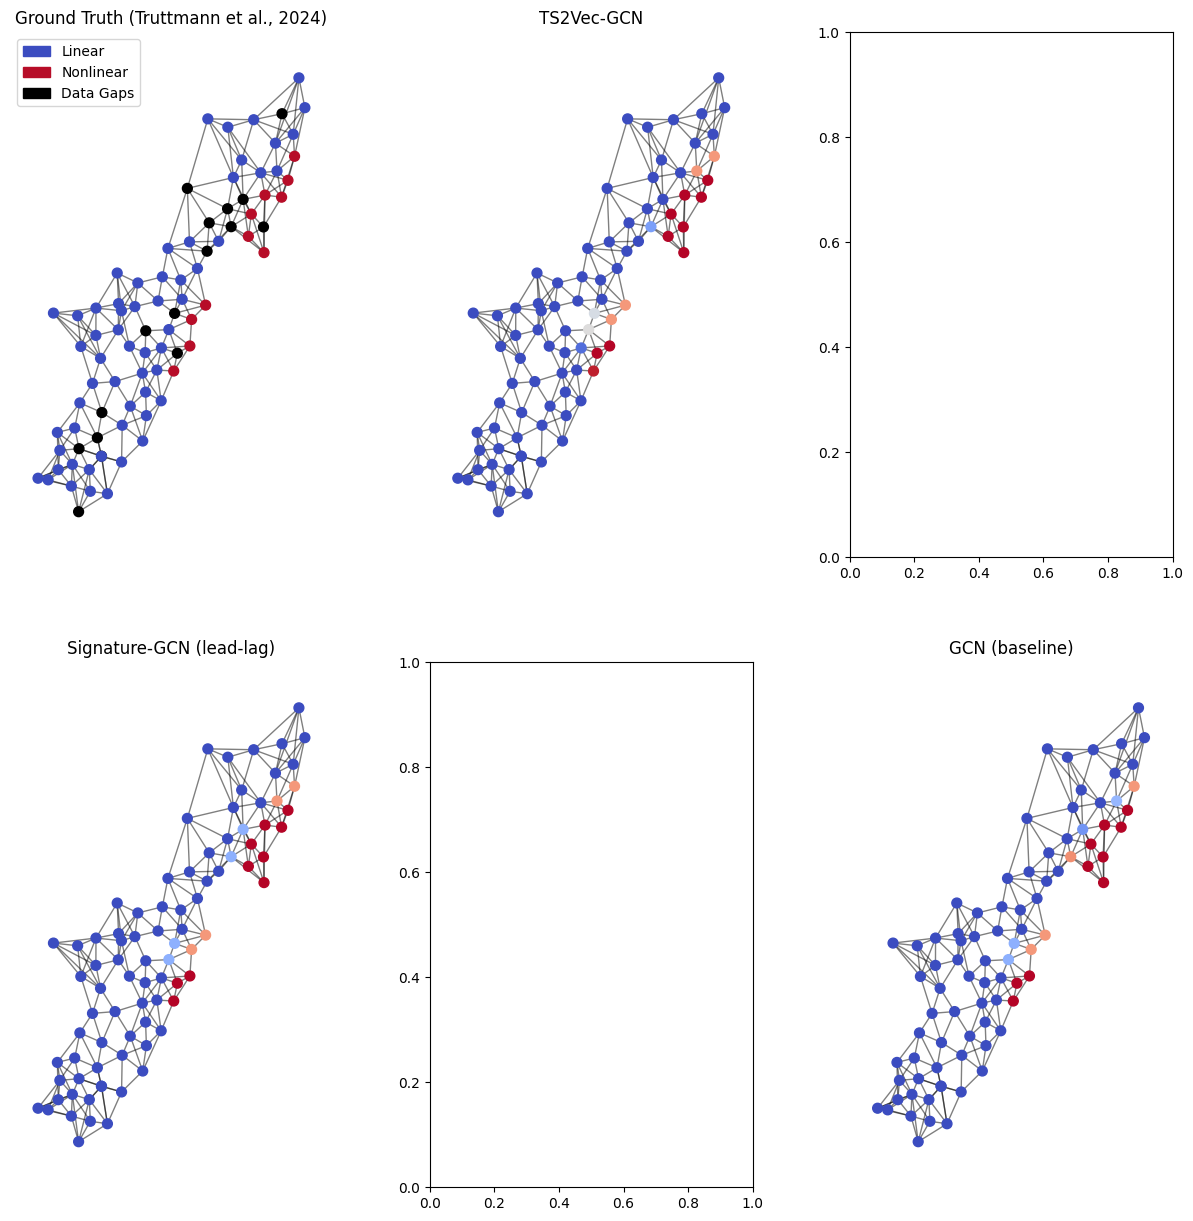

In [174]:
fig, axes = plt.subplots(2, 3, figsize=(15, 15))

# First plot: Mean Prediction
G = nx.Graph()
G.add_nodes_from(range(seq.num_nodes))
G.add_edges_from(seq[0].edge_index.T.tolist())

pos = {node: position.numpy() for node, position in enumerate(seq[0].pos)}
depth = {node: measurement.item() for node, measurement in enumerate(seq[0].y)}
vector_depth = np.array([depth[i] for i in range(len(depth))])

#-----------------------------------------#
# TS2Vec
#-----------------------------------------#

mean_prediction = ts2vec_pred.mean(axis=(0,1))

# Define color map based on mean predictions
cmap = plt.get_cmap('coolwarm')
node_colors = [cmap(mean_prediction[node]) for node in G.nodes]


axes[0,1].set_title('TS2Vec-GCN')
nx.draw_networkx_nodes(G, pos=pos, node_size=50, node_color=node_colors, ax=axes[0,1])
nx.draw_networkx_edges(G, pos=pos, ax=axes[0,1], alpha=0.5)
# nx.draw_networkx_labels(G, pos={k: (v[0], v[1] + 10000) for k, v in pos.items()}, labels={i: siteIDs[i] for i in range(len(siteIDs))}, font_size=8, ax=axes[1])
axes[0,1].axis('off')

#-----------------------------------------#
# Signature (lead-lag)
#-----------------------------------------#

mean_prediction = sig1_pred.mean(axis=(0,1))

# Define color map based on mean predictions
cmap = plt.get_cmap('coolwarm')
node_colors = [cmap(mean_prediction[node]) for node in G.nodes]

axes[1,0].set_title('Signature-GCN (lead-lag)')
nx.draw_networkx_nodes(G, pos=pos, node_size=50, node_color=node_colors, ax=axes[1,0])
nx.draw_networkx_edges(G, pos=pos, ax=axes[1,0], alpha=0.5)
# nx.draw_networkx_labels(G, pos={k: (v[0], v[1] + 10000) for k, v in pos.items()}, labels={i: siteIDs[i] for i in range(len(siteIDs))}, font_size=8, ax=axes[1])
axes[1,0].axis('off')

#-----------------------------------------#
# Random
#-----------------------------------------#

mean_prediction = rand_pred.mean(axis=(0,1))

# Define color map based on mean predictions
cmap = plt.get_cmap('coolwarm')
node_colors = [cmap(mean_prediction[node]) for node in G.nodes]

axes[1,2].set_title('GCN (baseline)')
nx.draw_networkx_nodes(G, pos=pos, node_size=50, node_color=node_colors, ax=axes[1,2])
nx.draw_networkx_edges(G, pos=pos, ax=axes[1,2], alpha=0.5)
# nx.draw_networkx_labels(G, pos={k: (v[0], v[1] + 10000) for k, v in pos.items()}, labels={i: siteIDs[i] for i in range(len(siteIDs))}, font_size=8, ax=axes[1])
axes[1,2].axis('off')

#-----------------------------------------#
# Ground Truth
#-----------------------------------------#

color_map = {0: cmap(0), -1: 'black', 1: cmap(0.99)}
node_colors = [color_map[depth[node]] for node in G.nodes]

axes[0,0].set_title('Ground Truth (Truttmann et al., 2024)')
nx.draw_networkx_nodes(G, pos=pos, node_size=50, node_color=node_colors, ax=axes[0,0])
nx.draw_networkx_edges(G, pos=pos, ax=axes[0,0], alpha=0.5)
# nx.draw_networkx_labels(G, pos={k: (v[0], v[1] + 10000) for k, v in pos.items()}, labels={i: siteIDs[i] for i in range(len(siteIDs))}, font_size=6, ax=axes[0])
axes[0,0].axis('off')

# Create legend
linear_patch = mpatches.Patch(color=cmap(0), label='Linear')
nonlinear_patch = mpatches.Patch(color=cmap(0.99), label='Nonlinear')
unlabeled_patch = mpatches.Patch(color='black', label='Data Gaps')
axes[0,0].legend(handles=[linear_patch, nonlinear_patch, unlabeled_patch])

# Adjust space between figures
plt.subplots_adjust(wspace=0.3)

# Title
plt.show()


## Regression

In [81]:
# packages
import torch
import pandas as pd
from pygsig.datasets.subduction import SubductionZone
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from ts2vec import ts2vec

In [82]:
from torch_geometric_temporal.signal.train_test_split import temporal_signal_split

test_dataset.task = "regression"
seq = test_dataset.get_graph(k=5)



In [ ]:
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
from sklearn.preprocessing import StandardScaler
import pygsig.graph 
import pygsig.models
import pygsig.signature
from pygsig.models import GCNClassification,MLPClassification
from pygsig.graph import split_nodes
from pygsig.transforms import SignatureFeatures,TS2VecFeatures,RandomFeatures
from ts2vec.ts2vec import TS2Vec
import signatory


# Set up parameters
num_nodes = seq.num_nodes
num_splits = 4
num_trials = 10
num_epochs = 200
learning_rate = 1e-3
in_channels = signatory.signature_channels(2*seq.num_node_features,3)
num_hidden = 64

print_during_training = False
retrain_encoder = False

# Create class weights for handling imbalance
positive_class_count = (seq.y == 1).sum().item()
negative_class_count = (seq.y == 0).sum().item()
class_weights = torch.tensor([negative_class_count / positive_class_count], dtype=torch.float)

# Initialize models
models = []
models.append(GCNClassification(num_channels=[in_channels, num_hidden, num_hidden, 1]))

model_names = ['GCN']

# Create a mask for valid labels (ignoring -1)
label_mask = seq.y != -1

# Criterion for binary classification with BCEWithLogitsLoss
criterion = nn.MSELoss()

for model_number, model in enumerate(models):
    print(f'Model: {model._get_name()}')
    print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Initialize arrays to store losses
    train_losses = np.zeros([num_splits, num_trials, num_epochs])
    eval_losses = np.zeros([num_splits, num_trials, num_epochs])
    
    rmse = np.zeros([num_splits, num_trials])
    mae = np.zeros([num_splits, num_trials])
    predictions = np.zeros([num_splits,num_trials,num_nodes])
    
    splits = split_nodes(num_nodes, num_splits, seed=31) # no validation
    
    for split in range(num_splits):
        print(f'Split {split+1}/{num_splits}')
        train_indices, test_indices = splits[split]
        
        # Create masks for training, evaluation, and testing
        train_mask = torch.zeros(num_nodes, dtype=torch.bool)
        test_mask = torch.zeros(num_nodes, dtype=torch.bool)
        
        train_mask[train_indices] = True
        test_mask[test_indices] = True
        
        # Apply label mask to exclude -1 values
        valid_train_mask = train_mask & label_mask
        valid_test_mask = test_mask & label_mask

        if retrain_encoder:
            # train encoder on the training data
            X_train = test_dataset.X[train_mask]
            encoder = TS2Vec(input_dims=3,device='cpu', hidden_dims=64, output_dims=in_channels,batch_size=1)
            loss_log = encoder.fit(X_train,verbose=True)
            torch.save(encoder,f'encoders/geonet/splits/TS2Vec_{split}.pt')
        else:
            # load encoder if already trained
            encoder = torch.load(f'encoders/geonet/splits/TS2Vec_{split}.pt')
        
        # Apply signature transformation to the sequential data to obtain static graph
        ts2vec = TS2VecFeatures(encoder,normalize=False)
        data = ts2vec(seq)

        with tqdm(total=num_trials, disable=print_during_training) as pbar:
            for trial in range(num_trials):
                model.reset_parameters()
                for epoch in range(num_epochs):
                    # Training phase
                    model.train()
                    optimizer.zero_grad()
                    out = model(data.x, data.edge_index)
                    
                    # Apply valid train mask to loss computation
                    train_loss = criterion(out[valid_train_mask], seq.y[valid_train_mask].unsqueeze(1))
                    train_loss.backward()
                    optimizer.step()

                    # Evaluation phase
                    model.eval()
                    with torch.no_grad():
                        test_loss = criterion(out[valid_test_mask], seq.y[valid_test_mask].unsqueeze(1))
                        train_losses[split, trial, epoch] = train_loss.item()
                    
                    if epoch % 10 == 0 and print_during_training:
                        print(f'Split {split}, Trial {trial}, Epoch {epoch}, Train Loss: {train_loss.item():.4f}')

                # Evaluation on test set with valid labels
                with torch.no_grad():
                    out = model(data.x, data.edge_index, data.edge_attr)
                    y_true = data.y.unsqueeze(1)
                    y_pred = (out > 0.5).float()  # Binary predictions
                    
                    # Compute performance metrics
                    rmse[split, trial] = np.sqrt(mean_squared_error(y_true[valid_test_mask].numpy(), y_pred[valid_test_mask].numpy()))
                    mae[split, trial] = mean_absolute_error(y_true[valid_test_mask].numpy(), y_pred[valid_test_mask].numpy())
                    f1[split, trial] = f1_score(y_true[valid_test_mask].numpy(), y_pred[valid_test_mask].numpy(), zero_division=0)
                    precision[split, trial] = precision_score(y_true[valid_test_mask].numpy(), y_pred[valid_test_mask].numpy(),zero_division=0)
                    recall[split, trial] = recall_score(y_true[valid_test_mask].numpy(), y_pred[valid_test_mask].numpy(), zero_division=0)
                    predictions[split,trial] = y_pred.squeeze().numpy()

                    # Update the progress bar
                    pbar.update(1)


    # Print results for the model
    print(f'Accuracy: {np.mean(accuracy):.4f} ± {np.std(accuracy):.4f}, F1: {np.mean(f1):.4f} ± {np.std(f1):.4f}, Precision: {np.mean(precision):.4f} ± {np.std(precision):.4f}, Recall: {np.mean(recall):.4f} ± {np.std(recall):.4f}')

    # Plotting the training and evaluation loss
    avg_train_losses = np.mean(train_losses, axis=(0, 1))
    std_train_losses = np.std(train_losses, axis=(0, 1))
 

    plt.figure()
    plt.plot(avg_train_losses, label='Train Loss', color='maroon')
    plt.fill_between(range(num_epochs), avg_train_losses - std_train_losses, avg_train_losses + std_train_losses, alpha=0.1, color='maroon')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_names[model_number]}')
    plt.legend()
    plt.show()


    # Plot confusion matrices
    cm = confusion_matrices.mean(axis=1).sum(axis=0)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt=".0f", cmap="Blues", xticklabels=['Linear', 'Nonlinear'], yticklabels=['Linear', 'Nonlinear'])
    plt.title(f'TS2Vec-GCN')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    plt.show()

## Forecasting

In [187]:
from torch_geometric_temporal.nn.recurrent import GConvGRU

import torch
import torch.nn 

class GCRNN(nn.Module):
    def __init__(self, num_channels,filter_size):
        super(GCRNN, self).__init__()
        self.gru1 = GConvGRU(num_channels[0], num_channels[-2], K=filter_size)
        self.gru2 = GConvGRU(num_channels[-2], num_channels[-1], K=filter_size)
    def forward(self, x, edge_index, edge_attr):
        x = self.gru1(x, edge_index, edge_attr)
        x = self.gru2(x, edge_index, edge_attr)
        return x


In [13]:
import numpy as np

np.stack(seq.features).transpose(1,0,-1).shape

(86, 1461, 3)

In [14]:
seq